# Purpose

### 2021-10-25
In this notebook I'll select the clusters for the One Feed experiment for DE to DE subreddits.

From manual inspection on mlflow GUI the best candidate is:<br>
`134cefe13ae34621a69fcc48c4d5fb71`

Because:
- it has high scores at the 100-to-200 & 200-to-300 bins 
- AND has the most subreddits (filtered out fewer subreddits due to low post counts)

Other clusters had slightly higher values at the 200-to-300 bin, but they clustered fewer subreddits.

# Imports & notebook setup

In [1]:
%load_ext google.colab.data_table

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# colab auth for BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
# Attach google drive & import my python utility functions
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
l_paths_to_append = [
    '/content/gdrive/MyDrive/Colab Notebooks',

    # need to append the path to subclu so that colab can import things properly
    '/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n'
]
for path_ in l_paths_to_append:
    if not path_ in sys.path:
        print(f"Appending: {path_}")
        sys.path.append(path_)

Mounted at /content/gdrive
Appending: /content/gdrive/MyDrive/Colab Notebooks
Appending: /content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n


In [5]:
# Regular Imports
import os
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [10]:
## install subclu & libraries needed to read parquet files from GCS

# !pip install -e "/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n/"

In [28]:
# Install needed to load data from GCS, for some reason not included in subclu?
# !pip install gcsfs

In [12]:
# !pip list

In [13]:
# subclu imports

# For reloading, need to force-delete some imported items
try:
    del LoadPosts, LoadSubreddits
except Exception:
    pass

from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.data.data_loaders import LoadPosts, LoadSubreddits
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)


setup_logging()
print_lib_versions([pd, np])

python		v 3.7.12
===
pandas		v: 1.1.5
numpy		v: 1.19.5


# Load subreddit metadata

This data is already in bigQuery so read it straight from there. We'll use it to filter out geo-relevant (German) subs.

Also add the latest ratings so that we can filter based on those.

In [20]:
%%time

sql_geo_and_languages = f"""
-- select DE subreddits + get latest rating

SELECT 
    sl.subreddit_id
    , sl.subreddit_name
    , r.rating
    -- , r.subrating
    , r.version

    , slo.verdict
    , slo.quarantine

    , geo.country_name
    , geo.users_percent_in_country
    -- , sl.geo_relevant_countries
    , ambassador_subreddit
    , posts_for_modeling_count

    , primary_post_language
    , primary_post_language_percent
    , secondary_post_language
    , secondary_post_language_percent

    , geo_relevant_country_count
    , geo_relevant_country_codes
    , geo_relevant_subreddit

FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_languages` sl
LEFT JOIN (
    SELECT * FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
    # Look back 2 days because looking back 1-day could be an empty partition
    WHERE dt = (CURRENT_DATE() - 2)
) AS slo
    ON slo.subreddit_id = sl.subreddit_id
LEFT JOIN (
    SELECT * FROM `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
    WHERE country_name = 'Germany'
) AS geo 
    ON sl.subreddit_id = geo.subreddit_id
LEFT JOIN (
    SELECT * FROM ds_v2_subreddit_tables.subreddit_ratings
    WHERE pt = '2021-10-24'
) AS r
    ON r.subreddit_id = sl.subreddit_id 
    
WHERE 1=1
    -- AND r.version = 'v2'
    -- AND COALESCE(r.rating, '') IN ('pg', 'pg13', 'g')
    AND COALESCE(slo.verdict, '') != 'admin-removed'
    AND COALESCE(slo.quarantine, false) != true
    AND (
        sl.geo_relevant_countries LIKE '%Germany%'
        OR sl.ambassador_subreddit = True
    )

ORDER BY users_percent_in_country ASC -- subreddit_name, ambassador_subreddit
;
"""

client = bigquery.Client()
df_geo_and_lang = client.query(sql_geo_and_languages).to_dataframe()
print(df_geo_and_lang.shape)

(838, 17)
CPU times: user 131 ms, sys: 12.7 ms, total: 144 ms
Wall time: 11.2 s


In [21]:
df_geo_and_lang.head()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
0,t5_4ckovw,buehne,None,None,None,False,None,NaN,True,9.0,German,0.333333,Danish,0.111111,NaN,None,False
1,t5_4p0iav,de_events,None,None,None,False,None,NaN,True,1.0,German,1.000000,None,NaN,NaN,None,False
2,t5_2otu32,nikolacorporation,pg,v3,None,False,Germany,0.160008,False,188.0,English,0.920213,Estonian,0.010638,1.0,DE,True
3,t5_vwvbb,vanmoofbicycle,pg,v1,None,False,Germany,0.160199,False,305.0,English,0.963934,None,NaN,1.0,DE,True
4,t5_2rq3g,trackmania,pg,v1,None,False,Germany,0.160615,False,958.0,English,0.927975,None,NaN,1.0,DE,True


In [22]:
df_geo_and_lang.tail()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
833,t5_2tz7b,braunschweig,None,None,None,False,Germany,0.956430,False,28.0,German,0.892857,English,0.071429,1.0,DE,True
834,t5_3255n,duschgedanken,None,None,None,False,Germany,0.956434,True,90.0,German,1.000000,None,NaN,1.0,DE,True
835,t5_2w4vt,bielefeld,None,None,None,False,Germany,0.957314,False,27.0,German,0.925926,English,0.037037,1.0,DE,True
836,t5_2ty5z,bundeswehr,None,None,None,False,Germany,0.959926,False,254.0,German,0.960630,English,0.031496,1.0,DE,True
837,t5_4o0ba2,nachthimmel,None,None,None,False,Germany,1.000000,True,18.0,German,0.833333,English,0.111111,NaN,None,False


# Load model labels

Ideally we could just pull the configuration data from github, but for now I'm just manually copying the artifact locations


In [14]:
config_clust_v040 = LoadHydraConfig(
    config_name='v0.4.0_2021_10_14-use_multi_lower_case_false_00',
    config_path="../config/data_embeddings_to_cluster",
)

In [25]:
run_uuid = '134cefe13ae34621a69fcc48c4d5fb71'
run_artifacts_uri = (
    'gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts'
)

gs_optimal_ks = f"{run_artifacts_uri}/optimal_ks/optimal_ks.parquet"
gs_model_labels = f"{run_artifacts_uri}/df_labels/df_labels.parquet"

### optimal values for K (cluster number)

In [29]:
%%time
df_opt_ks = pd.read_parquet(gs_optimal_ks)
print(df_opt_ks.shape)

(7, 2)
CPU times: user 312 ms, sys: 34 ms, total: 346 ms
Wall time: 2.77 s


### Labels for many values of k

We'll use the optimal values to filter out & keep only the labels we's use for One Feed

In [30]:
%%time
df_labels = pd.read_parquet(gs_model_labels)
print(df_labels.shape)

(19053, 65)
CPU times: user 146 ms, sys: 33.6 ms, total: 180 ms
Wall time: 2.57 s


In [31]:
df_labels.head()

,model_leaves_list_order_left_to_right,subreddit_name,subreddit_id,primary_topic,posts_for_modeling_count,010_k_labels,014_k_labels,020_k_labels,030_k_labels,040_k_labels,050_k_labels,052_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,248_k_labels,250_k_labels,351_k_labels,405_k_labels,010_k-predicted-primary_topic,014_k-predicted-primary_topic,020_k-predicted-primary_topic,030_k-predicted-primary_topic,040_k-predicted-primary_topic,050_k-predicted-primary_topic,052_k-predicted-primary_topic,060_k-predicted-primary_topic,070_k-predicted-primary_topic,080_k-predicted-primary_topic,090_k-predicted-primary_topic,100_k-predicted-primary_topic,110_k-predicted-primary_topic,120_k-predicted-primary_topic,130_k-predicted-primary_topic,140_k-predicted-primary_topic,150_k-predicted-primary_topic,160_k-predicted-primary_topic,170_k-predicted-primary_topic,180_k-predicted-primary_topic,190_k-predicted-primary_topic,200_k-predicted-primary_topic,210_k-predicted-primary_topic,220_k-predicted-primary_topic,230_k-predicted-primary_topic,240_k-predicted-primary_topic,248_k-predicted-primary_topic,250_k-predicted-primary_topic,351_k-predicted-primary_topic,405_k-predicted-primary_topic
0,7400,0sanitymemes,t5_2qlzfy,Internet Culture and Memes,559.0,4,5,8,10,13,17,18,19,21,25,27,31,36,39,42,45,47,50,53,54,58,61,63,66,69,70,73,74,103,117,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming
1,8343,0xpolygon,t5_2qgijx,Crypto,1188.0,5,6,9,11,14,18,19,20,22,26,28,32,38,41,44,48,50,54,58,59,63,66,69,73,77,78,83,84,117,135,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
2,527,100gecs,t5_131dor,Music,275.0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,5,5,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
3,666,100kanojo,t5_2asd3o,Anime,286.0,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,6,6,6,6,7,7,Music,Television,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
4,7949,100thieves,t5_3e98s,Gaming,443.0,4,5,8,10,13,17,18,19,21,25,27,31,37,40,43,47,49,52,55,56,60,63,65,69,72,73,78,79,109,125,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming,Gaming


### Filter to only k-optimal columns

Makes it easy to remove noise & understand cut-offs better

In [63]:
l_cols_label_core = [
    'model_leaves_list_order_left_to_right',
    'posts_for_modeling_count',
    'subreddit_id',
    'subreddit_name',
    'primary_topic',
]

cols_top_k = [c for c in df_labels.columns if any(c.startswith(k_) for k_ in df_opt_ks[df_opt_ks['k'] >= 50]['col_prefix'].unique())]

counts_describe(df_labels[l_cols_label_core + cols_top_k])

,dtype,count,unique,unique-percent,null-count,null-percent
model_leaves_list_order_left_to_right,int64,"19,053","19,053",100.00%,0,0.00%
posts_for_modeling_count,float64,"19,053","1,175",6.17%,0,0.00%
subreddit_id,object,"19,053","19,053",100.00%,0,0.00%
subreddit_name,object,"19,053","19,053",100.00%,0,0.00%
primary_topic,object,"15,929",51,0.32%,"3,124",16.40%
052_k_labels,int32,"19,053",52,0.27%,0,0.00%
100_k_labels,int32,"19,053",100,0.52%,0,0.00%
248_k_labels,int32,"19,053",248,1.30%,0,0.00%
351_k_labels,int32,"19,053",351,1.84%,0,0.00%
405_k_labels,int32,"19,053",405,2.13%,0,0.00%


# Keep only labels for DE subreddits


In [64]:
l_ix_subs = ['subreddit_name', 'subreddit_id']

df_labels_de = (
    df_labels[l_cols_label_core + cols_top_k]
    .merge(
        df_geo_and_lang.drop(['posts_for_modeling_count'], axis=1),
        how='right',
        on=l_ix_subs,
    )
    .copy()
    .sort_values(by=['model_leaves_list_order_left_to_right'], ascending=True)
)

print(df_labels_de.shape)

(838, 29)


### Drop subs with too few posts

In the modeling process I drop subreddits with too few posts. We don't have recommendations for them, so let's drop them.

It would also not be a great experience to recommend dead subs.

In [65]:
df_labels_de['model_leaves_list_order_left_to_right'].isnull().sum()

33

In [66]:
df_labels_de = df_labels_de[
    ~df_labels_de['model_leaves_list_order_left_to_right'].isnull()
]
df_labels_de.shape

(805, 29)

In [80]:
l_cols_label_de = [c for c in df_labels_de.columns if c.endswith('k_labels')]
df_labels_de[l_cols_label_de] = df_labels_de[l_cols_label_de].astype(int)

In [81]:
style_df_numeric(
    df_labels_de.head(25),
    # rename_cols_for_display=True,
    l_bar_simple=[c for c in df_labels_de.columns if 'labels' in c]
)

,model_leaves_list_order_left_to_right,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic,052_k_labels,100_k_labels,248_k_labels,351_k_labels,405_k_labels,052_k-predicted-primary_topic,100_k-predicted-primary_topic,248_k-predicted-primary_topic,351_k-predicted-primary_topic,405_k-predicted-primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
33,49.00,18,t5_2roop,hardtechno,None,1,1,1,1,1,Music,Music,Music,Music,Music,None,None,None,False,Germany,0,False,English,77.78%,Dutch,5.56%,1,DE,True
152,76.00,386,t5_2qziu,rappers,None,1,1,1,1,1,Music,Music,Music,Music,Music,r,v2,admin-approved,False,Germany,0,False,English,81.87%,German,1.81%,1,DE,True
579,77.00,705,t5_2v7pv,germanrap,Music,1,1,1,1,1,Music,Music,Music,Music,Music,r,v2,None,False,Germany,1,False,German,71.49%,English,13.05%,1,DE,True
231,85.00,23,t5_2smd3,musik,None,1,1,1,1,1,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,82.61%,English,8.70%,1,DE,True
201,89.00,25,t5_39ea8,mgpmppjwfa,Music,1,1,1,1,1,Music,Music,Music,Music,Music,None,None,None,False,Germany,0,False,German,52.00%,English,8.00%,1,DE,True
245,95.00,179,t5_2t6i4,germusic,Music,1,1,1,1,1,Music,Music,Music,Music,Music,pg13,None,None,False,Germany,1,False,German,58.10%,English,21.23%,1,DE,True
549,172.00,17,t5_31l12,kollegah,Music,1,2,2,2,2,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,94.12%,Indonesian,5.88%,1,DE,True
320,173.00,19,t5_2ylk3,moneyboy,Music,1,2,2,2,2,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,84.21%,Danish,5.26%,1,DE,True
14,283.00,101,t5_2t36v,billytalent,Music,1,2,4,4,4,Music,Music,Music,Music,Music,r,v1,None,False,Germany,0,False,English,99.01%,Somali,0.99%,1,DE,True
15,370.00,37,t5_35q0o,lindemann,Music,1,2,4,4,4,Music,Music,Music,Music,Music,r,v2,None,False,Germany,0,False,English,91.89%,Danish,2.70%,1,DE,True


In [99]:
style_df_numeric(
    df_labels_de.tail(25),
    # rename_cols_for_display=True,
    l_bar_simple=[c for c in df_labels_de.columns if 'labels' in c]
)

,model_leaves_list_order_left_to_right,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic,052_k_labels,100_k_labels,248_k_labels,351_k_labels,405_k_labels,052_k-predicted-primary_topic,100_k-predicted-primary_topic,248_k-predicted-primary_topic,351_k-predicted-primary_topic,405_k-predicted-primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
241,"18,137.00",76,t5_2v6r0,tuberlin,Learning and Education,50,94,234,334,386,Learning and Education,Learning and Education,Learning and Education,Learning and Education,Learning and Education,pg,v3,None,False,Germany,1,False,English,89.47%,German,10.53%,1,DE,True
92,"18,138.00",129,t5_2zhyp,tumunich,Learning and Education,50,94,234,334,386,Learning and Education,Learning and Education,Learning and Education,Learning and Education,Learning and Education,None,None,None,False,Germany,0,False,English,98.45%,German,1.55%,1,DE,True
581,"18,273.00",16,t5_k4uk5,versicherung,None,50,94,236,336,388,Learning and Education,Learning and Education,Careers,Careers,Careers,None,None,None,False,Germany,1,False,German,100.00%,None,-,1,DE,True
440,"18,282.00",13,t5_32ayp,medizin,Medical and Mental Health,50,94,236,336,388,Learning and Education,Learning and Education,Careers,Careers,Careers,None,None,None,False,Germany,1,False,German,100.00%,None,-,1,DE,True
796,"18,333.00",60,t5_3grce,lehrerzimmer,Learning and Education,50,94,237,337,389,Learning and Education,Learning and Education,Learning and Education,Learning and Education,Learning and Education,pg,None,None,False,Germany,1,False,German,100.00%,None,-,1,DE,True
354,"18,375.00",11,t5_4lced8,geschlechtsneutral,Activism,50,94,237,338,390,Learning and Education,Learning and Education,Learning and Education,Science,Science,None,None,None,False,Germany,1,False,German,100.00%,None,-,1,DE,True
283,"18,393.00",937,t5_41u8uv,surveycircle_de,None,50,94,237,338,390,Learning and Education,Learning and Education,Learning and Education,Science,Science,None,None,None,False,Germany,1,False,German,80.90%,English,9.39%,1,DE,True
465,"18,395.00",58,t5_37u1s,samplesize_dach,None,50,94,237,338,390,Learning and Education,Learning and Education,Learning and Education,Science,Science,None,None,None,False,Germany,1,False,German,94.83%,English,5.17%,1,DE,True
357,"18,396.00",35,t5_2p1qpt,umfragen,None,50,94,237,338,390,Learning and Education,Learning and Education,Learning and Education,Science,Science,None,None,None,False,Germany,1,False,German,91.43%,English,5.71%,1,DE,True
214,"18,399.00",13,t5_39he0,luh,None,50,94,237,338,390,Learning and Education,Learning and Education,Learning and Education,Science,Science,None,None,None,False,Germany,0,False,German,84.62%,English,7.69%,1,DE,True


## Check if there are any single subreddits if we use cluster = 52

We want to avoid having clusters of one subreddit b/c that means we have nothing to recommend.

Looks like even at 52 there are some subreddits that are orphans.

In [78]:
?value_counts_and_pcts

In [82]:
value_counts_and_pcts(
    df_labels_de['052_k_labels'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
)

,052_k_labels,count,percent,cumulative_percent
0,9,84,10.4%,10.4%
1,7,70,8.7%,19.1%
2,49,54,6.7%,25.8%
3,12,50,6.2%,32.0%
4,21,41,5.1%,37.1%
5,47,37,4.6%,41.7%
6,23,37,4.6%,46.3%
7,18,34,4.2%,50.6%
8,6,33,4.1%,54.7%
9,20,33,4.1%,58.8%


In [93]:
df_lbl_counts = value_counts_and_pcts(
    df_labels_de['052_k_labels'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)

In [94]:
df_lbl_counts.tail()

,052_k_labels,count,percent,cumulative_percent
43,22,3,0.003727,0.992547
44,44,2,0.002484,0.995031
45,15,2,0.002484,0.997516
46,48,1,0.001242,0.998758
47,43,1,0.001242,1.000000


In [95]:
l_orphan_cluster_ids = df_lbl_counts.tail()['052_k_labels'].values

df_labels_de[df_labels_de['052_k_labels'].isin(l_orphan_cluster_ids)]

,model_leaves_list_order_left_to_right,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic,052_k_labels,100_k_labels,248_k_labels,351_k_labels,405_k_labels,052_k-predicted-primary_topic,100_k-predicted-primary_topic,248_k-predicted-primary_topic,351_k-predicted-primary_topic,405_k-predicted-primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
530,5837.0,38.0,t5_3ezif,pokemongogermany,None,15,23,55,77,88,Gaming,Gaming,Gaming,Gaming,Gaming,None,None,None,False,Germany,0.839662,False,German,0.921053,English,0.052632,1.0,DE,True
731,5861.0,150.0,t5_3wnb53,pokemonde,Gaming,15,23,55,77,88,Gaming,Gaming,Gaming,Gaming,Gaming,None,None,None,False,Germany,0.894578,True,German,0.806667,Swedish,0.033333,1.0,DE,True
252,9298.0,36.0,t5_2scyzx,damaghshow,Gaming,22,37,96,136,155,Place,Place,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,None,None,None,False,Germany,0.550459,False,Other_language,0.750000,Croatian,0.027778,1.0,DE,True
285,9319.0,53.0,t5_1bigl8,menchtv,None,22,37,96,136,155,Place,Place,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,None,None,None,False,Germany,0.622054,False,English,0.396226,Norwegian,0.094340,1.0,DE,True
39,9384.0,230.0,t5_50b08s,trendycow,None,22,37,97,137,156,Place,Place,Movies,Movies,Movies,None,None,None,False,Germany,0.172694,False,English,0.934783,Somali,0.008696,1.0,DE,True
608,15011.0,26.0,t5_35ipo,fitnessde,Fitness and Nutrition,43,74,188,269,312,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,pg,None,None,False,Germany,0.861554,False,German,1.000000,None,NaN,1.0,DE,True
328,15177.0,95.0,t5_49sepp,leande,Science,44,76,190,273,317,Medical and Mental Health,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,None,None,None,False,Germany,0.703629,False,German,0.652632,English,0.115789,1.0,DE,True
517,15187.0,154.0,t5_2zynz,drogen,Mature Themes and Adult Content,44,76,190,273,317,Medical and Mental Health,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,None,None,None,False,Germany,0.834762,False,German,0.961039,English,0.019481,1.0,DE,True
446,17047.0,62.0,t5_4ognal,zelten,Outdoors and Nature,48,89,222,318,367,Place,Music,Outdoors and Nature,Outdoors and Nature,Outdoors and Nature,None,None,None,False,Germany,0.801587,True,German,0.951613,French,0.016129,1.0,DE,True


# Reshape: flatten topics into 1 row = 1 cluster/topic

In [100]:
# # df_cluster_per_row = 
# (
#     df_labels_de[['052_k_labels', 'primary_topic', 'subreddit_name', 'subreddit_id']]
#     .set_index(['052_k_labels', 'primary_topic', 'subreddit_name'])
#     # [['subreddit_name']]
#     .unstack()
# )

In [133]:
%%time

df_cluster_per_row = (
    df_labels_de
    .groupby(['052_k_labels', '052_k-predicted-primary_topic'])
    ['subreddit_name']
    .agg(
        [
            ('subreddit_count', 'count'),
            ('list_of_subs', list)
        ]
    )
    .reset_index()
)

# Convert the list of subs into a df & merge back with original sub (each sub should be in a new column)
df_cluster_per_row = (
    df_cluster_per_row
    .merge(
        pd.DataFrame(df_cluster_per_row['list_of_subs'].to_list()).fillna(''),
        how='left',
        left_index=True,
        right_index=True,
    )
    .drop(['list_of_subs'], axis=1)
)

print(df_cluster_per_row.shape)

(48, 87)
CPU times: user 30.2 ms, sys: 14 µs, total: 30.3 ms
Wall time: 31.6 ms


In [138]:
df_labels_de[df_labels_de['subreddit_name'] == 'sexmeets1']

,model_leaves_list_order_left_to_right,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic,052_k_labels,100_k_labels,248_k_labels,351_k_labels,405_k_labels,052_k-predicted-primary_topic,100_k-predicted-primary_topic,248_k-predicted-primary_topic,351_k-predicted-primary_topic,405_k-predicted-primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
165,5129.0,12.0,t5_50c2v9,sexmeets1,None,13,20,48,67,76,Funny/Humor,Funny/Humor,Funny/Humor,Funny/Humor,Funny/Humor,None,None,None,False,Germany,0.321951,False,German,0.833333,English,0.166667,1.0,DE,True


In [137]:
df_cluster_per_row

,052_k_labels,052_k-predicted-primary_topic,subreddit_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,1,Music,13,hardtechno,rappers,germanrap,musik,mgpmppjwfa,germusic,kollegah,moneyboy,billytalent,lindemann,eskimocallboy,metallmaimais,avamax,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,Anime,5,mangade,ueber8000,violaafox,kpopde,terranigma,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,3,Television,5,southparkde,diesimpsons,seriennews,strangerthingsde,lazytown,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,4,"Reading, Writing, and Literature",3,selfpublish_de,buecher,harrypotterde,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,5,Movies,6,filme,streamen,dokumentationen,mediathek,marvelde,kriegdersterne,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,6,Mature Themes and Adult Content,33,jakictwinshot,veronika_pxn,itszoemervie,videozeugs,bonnylango,amandacemilia,antoniarotnudes_,alessiaaniki,celinaafox,simexexfreundin,germaninfluencersleak,hotgermanyoutuber,deutscheyoutuberinnen,geryoutuber,julesboringlifevideos,germanyoutuber,larawinter_,amandaemilia,celina_x31_of_leaks,nikasofiee,cxynxe,jujuistgeil,asmrjaninaonlyfans,jana_libra,nicoledobrikovoff,germanfaptribu,loredanahot_,elenakamperionly,katja_khodyreva,anjaweloveyou2,katjahotonlyfans,katjakrasaviconlyfans,snapnudesgruppedmme,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,7,Mature Themes and Adult Content,70,nicole_dobrikov,julia_beautx,laramarieconradsof,laramarieconradsonly,zoeywgr_onlyfans,sallydinosaur,juliaroemmelt,alexissheree,ellismom,jessyhartel,jolinamarieledl,asmr_charlie_,katikarenina,carlottabnk,missragehot,mareikefox,german_nudes_company,sarashionetteof,antoniarotonly,leniklum_,alexisshvantoniarotof,wixxverbandch,blasen,wixxkumpelsnuernberg,sexschleswigholstein,sextreffenhannover,sextreffennrw,nudesfromteens,freundintausch,veredelungen,loredana_zefi,itsmisabell,luisejenischnew,dagibeensfw,pamelareif,gemma_wren,annitheduckfuck,...,deutschefapcelebs,melodyraabbit1,heyleaxxx,laramarieconrads,larawinter_18plus,mariamalkk,michellemelody,pativalpati,cirizzlecindy,allyhuebner,anfr00angelina,leakatharinamariahot,loredana_shirinhot,sandralze,anica,maja1401,schildizzlhot,misslopes,nackt,videozeugshot,meiketosi,alinaxloves,simex_freundin,elizabethsanchezonlyf,mrs_sanchez,freenudesforyou,,,,,,,,,,,,,,
7,8,Mature Themes and Adult Content,15,elisaalineofs,isabellaspaeth,wixxzentrale,lillylagodka,lillylueesse,krassschulegirls,germancelebfeet,germanysnexttopmodel,celebrities322,sinadeinert,elena_nicoleonlyfans,lenaklenkeinsta,tamitilgner,jugenliche_nudes,lenaknk,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,9,Mature Themes and Adult Content,84,itsmisabell2,itsmisabellhot,lisaandlena,eyfreundin,julesboringlife1,lucylacht,juliajasminbtn,juliaschulzehot,daliamya,asmrjanina_cum,annakauernsfw,annaschmidti,einfachdaria,jessicasulikowski,marieland,evelynburdeckineu,kellymissesvlog,sylviemeis,katiktr,laurasophie,laurawoelki,barbieillginay,melissanaschenweng,nikasofie_hot,linabmn_hot,maylinjuelide_hot,aliciaawabeissert,ivanasantacruz,sarahposch,annalewandowska,salomeelena,lenagercke,lenalandrut,evegross,laurawontorra,jessica__belkin,alicaschmidt,...,helenefischer,sgjx,melinamsxou,sarashionette,silkyvinyl_,devideos,lisa_delpiero,bronnica,reginahixtof,nsfw_vide0s,marrilor_maribel,vanessa_mai_hot,kimlamarinn,lisadelpieroaktiv,popstantot_leaks,annesamanta,flying_mina,lotteee23,onlycom,zoeliss1,jamiielynn,marie_haecks,encahaxhia1,badmomzjaynew,corneliaritzke,sonnyloopshot,sophiacalate,sabrinekhan,wiktoriaryczko,ps_tussi,taynanew,yoncahagennew,jujuvierundvierzig,shirindavidaktiv,dilarahava,tigerlarizhot,sarahsaritaah,katarina__deme,laurama

In [118]:
pd.DataFrame(df_cluster_per_row['list_of_subs'].to_list()).fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,hardtechno,rappers,germanrap,musik,mgpmppjwfa,germusic,kollegah,moneyboy,billytalent,lindemann,eskimocallboy,metallmaimais,avamax,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,mangade,ueber8000,violaafox,kpopde,terranigma,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,southparkde,diesimpsons,seriennews,strangerthingsde,lazytown,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,selfpublish_de,buecher,harrypotterde,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,filme,streamen,dokumentationen,mediathek,marvelde,kriegdersterne,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,jakictwinshot,veronika_pxn,itszoemervie,videozeugs,bonnylango,amandacemilia,antoniarotnudes_,alessiaaniki,celinaafox,simexexfreundin,germaninfluencersleak,hotgermanyoutuber,deutscheyoutuberinnen,geryoutuber,julesboringlifevideos,germanyoutuber,larawinter_,amandaemilia,celina_x31_of_leaks,nikasofiee,cxynxe,jujuistgeil,asmrjaninaonlyfans,jana_libra,nicoledobrikovoff,germanfaptribu,loredanahot_,elenakamperionly,katja_khodyreva,anjaweloveyou2,katjahotonlyfans,katjakrasaviconlyfans,snapnudesgruppedmme,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,nicole_dobrikov,julia_beautx,laramarieconradsof,laramarieconradsonly,zoeywgr_onlyfans,sallydinosaur,juliaroemmelt,alexissheree,ellismom,jessyhartel,jolinamarieledl,asmr_charlie_,katikarenina,carlottabnk,missragehot,mareikefox,german_nudes_company,sarashionetteof,antoniarotonly,leniklum_,alexisshvantoniarotof,wixxverbandch,blasen,wixxkumpelsnuernberg,sexschleswigholstein,sextreffenhannover,sextreffennrw,nudesfromteens,freundintausch,veredelungen,loredana_zefi,itsmisabell,luisejenischnew,dagibeensfw,pamelareif,gemma_wren,annitheduckfuck,elizabeth_sanchez,elizabeth_sanchez_of,germanmilfundteen,...,deutschefapcelebs,melodyraabbit1,heyleaxxx,laramarieconrads,larawinter_18plus,mariamalkk,michellemelody,pativalpati,cirizzlecindy,allyhuebner,anfr00angelina,leakatharinamariahot,loredana_shirinhot,sandralze,anica,maja1401,schildizzlhot,misslopes,nackt,videozeugshot,meiketosi,alinaxloves,simex_freundin,elizabethsanchezonlyf,mrs_sanchez,freenudesforyou,,,,,,,,,,,,,,
7,elisaalineofs,isabellaspaeth,wixxzentrale,lillylagodka,lillylueesse,krassschulegirls,germancelebfeet,germanysnexttopmodel,celebrities322,sinadeinert,elena_nicoleonlyfans,lenaklenkeinsta,tamitilgner,jugenliche_nudes,lenaknk,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,itsmisabell2,itsmisabellhot,lisaandlena,eyfreundin,julesboringlife1,lucylacht,juliajasminbtn,juliaschulzehot,daliamya,asmrjanina_cum,annakauernsfw,annaschmidti,einfachdaria,jessicasulikowski,marieland,evelynburdeckineu,kellymissesvlog,sylviemeis,katiktr,laurasophie,laurawoelki,barbieillginay,melissanaschenweng,nikasofie_hot,linabmn_hot,maylinjuelide_hot,aliciaawabeissert,ivanasantacruz,sarahposch,annalewandowska,salomeelena,lenagercke,lenalandrut,evegross,laurawontorra,jessica__belkin,alicaschmidt,rossellafiamingo,kirakosarin,sissorhot,...,helenefischer,sgjx,melinamsxou,sarashionette,silkyvinyl_,devideos,lisa_delpiero,bronnica,reginahixtof,nsfw_vide0s,marrilor_maribel,vanessa_mai_hot,kimlamarinn,lisadelpieroaktiv,popstantot_leaks,annesamanta,flying_mina,lotteee23,onlycom,zoeliss1,jamiielynn,marie_haecks,encahaxhia1,badmomzjaynew,corneliaritzke,sonnyloopshot,sophiacalate,sabrinekhan,wiktoriaryczko,ps_tussi,taynanew,yoncahagennew,jujuvierundvierzig,shirindavidaktiv,dilarahava,tigerlarizhot,sarahsaritaah,katarina__deme,lauramariarypa,karna_val
9,katzengruppe,kratzbaum,collie,hundeschule,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
LEGACY

# Upload to BigQuery

In [ ]:
df_sim_pair_for_bq.shape

(3838400, 26)

In [ ]:
%%time

from datetime import datetime

(
    df_sim_pair_for_bq
    .assign(table_creation_date=datetime.utcnow().date())
    .assign(mlflow_run_uuid=config_clust_v040.config_dict['run_uuid'])
    .to_gbq(
        destination_table='david_bermejo.subclu_v0040_subreddit_distances_c_top_200',
        project_id='reddit-employee-datasets',
        chunksize=100000,
        if_exists='replace',
    )
)

100000 out of 3838400 rows loaded."
200000 out of 3838400 rows loaded."
300000 out of 3838400 rows loaded."
400000 out of 3838400 rows loaded."
500000 out of 3838400 rows loaded."
600000 out of 3838400 rows loaded."
700000 out of 3838400 rows loaded."
800000 out of 3838400 rows loaded."
900000 out of 3838400 rows loaded."
1000000 out of 3838400 rows loaded."
1100000 out of 3838400 rows loaded."
1200000 out of 3838400 rows loaded."
1300000 out of 3838400 rows loaded."
1400000 out of 3838400 rows loaded."
1500000 out of 3838400 rows loaded."
1600000 out of 3838400 rows loaded."
1700000 out of 3838400 rows loaded."
1800000 out of 3838400 rows loaded."
1900000 out of 3838400 rows loaded."
2000000 out of 3838400 rows loaded."
2100000 out of 3838400 rows loaded."
2200000 out of 3838400 rows loaded."
2300000 out of 3838400 rows loaded."
2400000 out of 3838400 rows loaded."
2500000 out of 3838400 rows loaded."
2600000 out of 3838400 rows loaded."
2700000 out of 3838400 rows loaded."
2800000 ou

CPU times: user 1min 41s, sys: 2.87 s, total: 1min 44s
Wall time: 8min 24s


# Check distribution of cosine for top 200 subs

Maybe we can use a limit of cosine distance instead of limiting to top 200?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


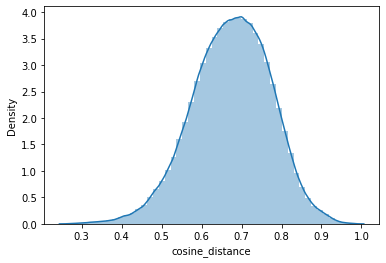

In [ ]:
sns.distplot(df_sim_pair_for_bq['cosine_distance'])

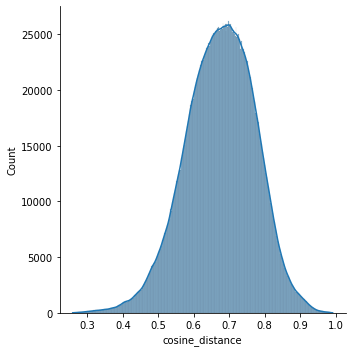

In [ ]:
sns.displot(df_sim_pair_for_bq['cosine_distance'], kde=True)

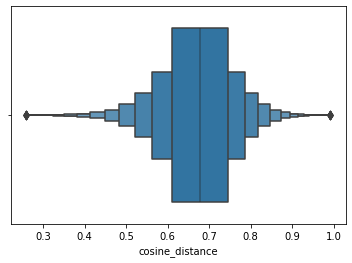

In [ ]:
ax = sns.boxenplot(x=df_sim_pair_for_bq['cosine_distance'])

### Distribution for top 20 only

If we do top 20 we might get a better idea of where to draw he line for cosine distance.  There are still some subs that might be really unique and might have few matches, though.

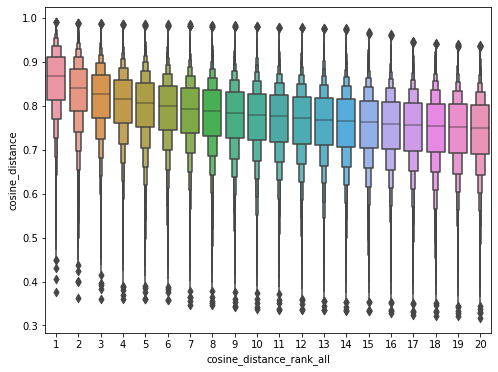

In [ ]:
fig = plt.figure(figsize=(8, 6))

df_plot_ = (
    df_sim_pair_for_bq
    .query("cosine_distance_rank_all <= 20")
)

ax = sns.boxenplot(
    data=df_plot_,
    y='cosine_distance',
    x='cosine_distance_rank_all',
)
plt.show()

In [ ]:
(
    df_sim_pair_for_bq
    .query("cosine_distance_rank_all <= 1 & cosine_distance <= 0.45")
)

,cosine_distance,cosine_distance_rank_all,subreddit_name_a,subreddit_name_b,primary_post_language_a,primary_post_language_b,geo_relevant_countries_a,geo_relevant_countries_b,ambassador_subreddit_a,ambassador_subreddit_b,subreddit_id_a,subreddit_id_b,post_median_word_count_a,post_median_word_count_b,primary_post_language_percent_a,secondary_post_language_a,secondary_post_language_percent_a,geo_relevant_country_count_a,geo_relevant_country_codes_a,geo_relevant_subreddit_a,primary_post_language_percent_b,secondary_post_language_b,secondary_post_language_percent_b,geo_relevant_country_count_b,geo_relevant_country_codes_b,geo_relevant_subreddit_b
141800,0.430873,1,analisa_kebaili,anasoclash,Indonesian,Other_language,France,Mexico,False,False,t5_4nd8tf,t5_4wqy55,2.0,1.0,0.875000,Tagalog,0.125000,1.0,FR,True,0.672043,Spanish,0.010753,1.0,MX,True
572712,0.448685,1,incestmemes,adoption,Arabic,English,India,None,False,False,t5_ljtxt,t5_2qr1s,1.0,185.0,1.000000,None,NaN,1.0,IN,True,1.000000,None,NaN,NaN,None,False
964112,0.449496,1,machinebtp,guadeloupe,French,French,France,France,False,False,t5_y9p0i,t5_2xnq1,19.0,12.0,0.940833,English,0.020000,1.0,FR,True,0.975278,None,NaN,1.0,FR,True
2518198,0.405346,1,travesti,traandwagon,Turkish,English,Brazil,None,False,False,t5_35a2w,t5_wf7tn,32.0,7.0,0.818182,English,0.090909,1.0,BR,True,0.825648,Danish,0.017291,NaN,None,False
3372340,0.375380,1,de_events,concerts,German,English,None,None,True,False,t5_4p0iav,t5_2ql3p,9.0,34.0,1.000000,None,NaN,NaN,None,False,0.938462,Spanish,0.023077,NaN,None,False


## QA / test

In [ ]:
mask_cricket = df_sim_pair_top['subreddit_name_a'].str.contains('cricket')
mask_regg = df_sim_pair_top['subreddit_name_a'].str.contains('regga')
mask_futbol = df_sim_pair_top['subreddit_name_a'].str.contains('futbol')
mask_united = df_sim_pair_top['subreddit_name_a'].str.contains('united')
# mask_cubs = df_sim_pair_top['subreddit_name_a'].str.contains('cubs')
# mask_bears = df_sim_pair_top['subreddit_name_a'].str.contains('bears')

mask_misc = (
    (df_sim_pair_top['subreddit_name_a'].str.contains('gme_'))
    | (df_sim_pair_top['subreddit_name_a'].str.contains('inversi')) 
)

df_test = (
    df_sim_pair_top
    [
        mask_cricket | mask_regg 
        | mask_misc
        # | mask_futbol | mask_united |
        # mask_cubs | mask_bears
    ]
)
df_test.shape

(4200, 11)

In [ ]:
value_counts_and_pcts(df_test['subreddit_name_a'])

,subreddit_name_a-count,subreddit_name_a-percent,subreddit_name_a-pct_cumulative_sum
inversionesmexico,200,4.8%,4.8%
gme_meltdown,200,4.8%,9.5%
cricketcopypastas,200,4.8%,14.3%
cricketbuddies,200,4.8%,19.0%
cricketmemesforlife,200,4.8%,23.8%
cricket,200,4.8%,28.6%
cricketwireless,200,4.8%,33.3%
cricket19,200,4.8%,38.1%
emergingcricket,200,4.8%,42.9%
reggaeton,200,4.8%,47.6%


# QA some subreddits

quick spot check to see how the new models are doing

In [ ]:
(
    df_test[df_test['cosine_distance_rank'] <= 5]
)

,subreddit_id_a,subreddit_id_b,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b,cosine_distance_rank
344112,t5_45kmib,t5_3q8lpf,0.837875,gme_capitalists,deepfuckingvalue,0.017751,0.006192,uncategorized,uncategorized,14.0,22.0,1.0
344113,t5_45kmib,t5_43zwn1,0.814532,gme_capitalists,superstonk,0.017751,0.016667,uncategorized,uncategorized,14.0,13.0,2.0
344114,t5_45kmib,t5_43klu5,0.812574,gme_capitalists,gmeamcstonks,0.017751,0.011396,uncategorized,uncategorized,14.0,12.0,3.0
344115,t5_45kmib,t5_48nz4l,0.807114,gme_capitalists,gmejungle,0.017751,0.005833,uncategorized,uncategorized,14.0,11.0,4.0
344116,t5_45kmib,t5_46vgjg,0.805626,gme_capitalists,moass,0.017751,0.000000,uncategorized,uncategorized,14.0,13.5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3572340,t5_vrs1j,t5_2qhe0,0.806338,emergingcricket,cricket,0.000000,0.001667,sports,uncategorized,11.0,14.0,1.0
3572341,t5_vrs1j,t5_31z5ua,0.755893,emergingcricket,cricketaus,0.000000,0.027397,sports,uncategorized,11.0,12.0,2.0
3572342,t5_vrs1j,t5_37n2x,0.745901,emergingcricket,pakcricket,0.000000,0.000000,sports,uncategorized,11.0,11.5,3.0
3572343,t5_vrs1j,t5_2rnjo,0.740376,emergingcricket,ipl,0.000000,0.012346,sports,sports,11.0,11.0,4.0


## Save all the subs to rate, include user counts & flag for whether sub was included in v31 or v32

In [ ]:
# (
#     df_v32[df_v32['subreddit_name'].isin(set_subs_de_or_ambassador)]
#     .sort_values(by=['users_l28', 'posts_l28'], ascending=False)
#     .reset_index(drop=True)
#     .to_csv("/content/gdrive/MyDrive/Colab Notebooks/data/All_DE_subreddits_in_v0.3.2_to_tag.csv")
# )